# Differences from Attention is All You Need Transformer:
- It's a Decoder-only model (The cross-attention mechanism is removed)
- The LayerNorm was moved to the input of each sub-block, instead of the output
- Additional LayerNorm was added after the final self-attention block (Before the Linear layer)

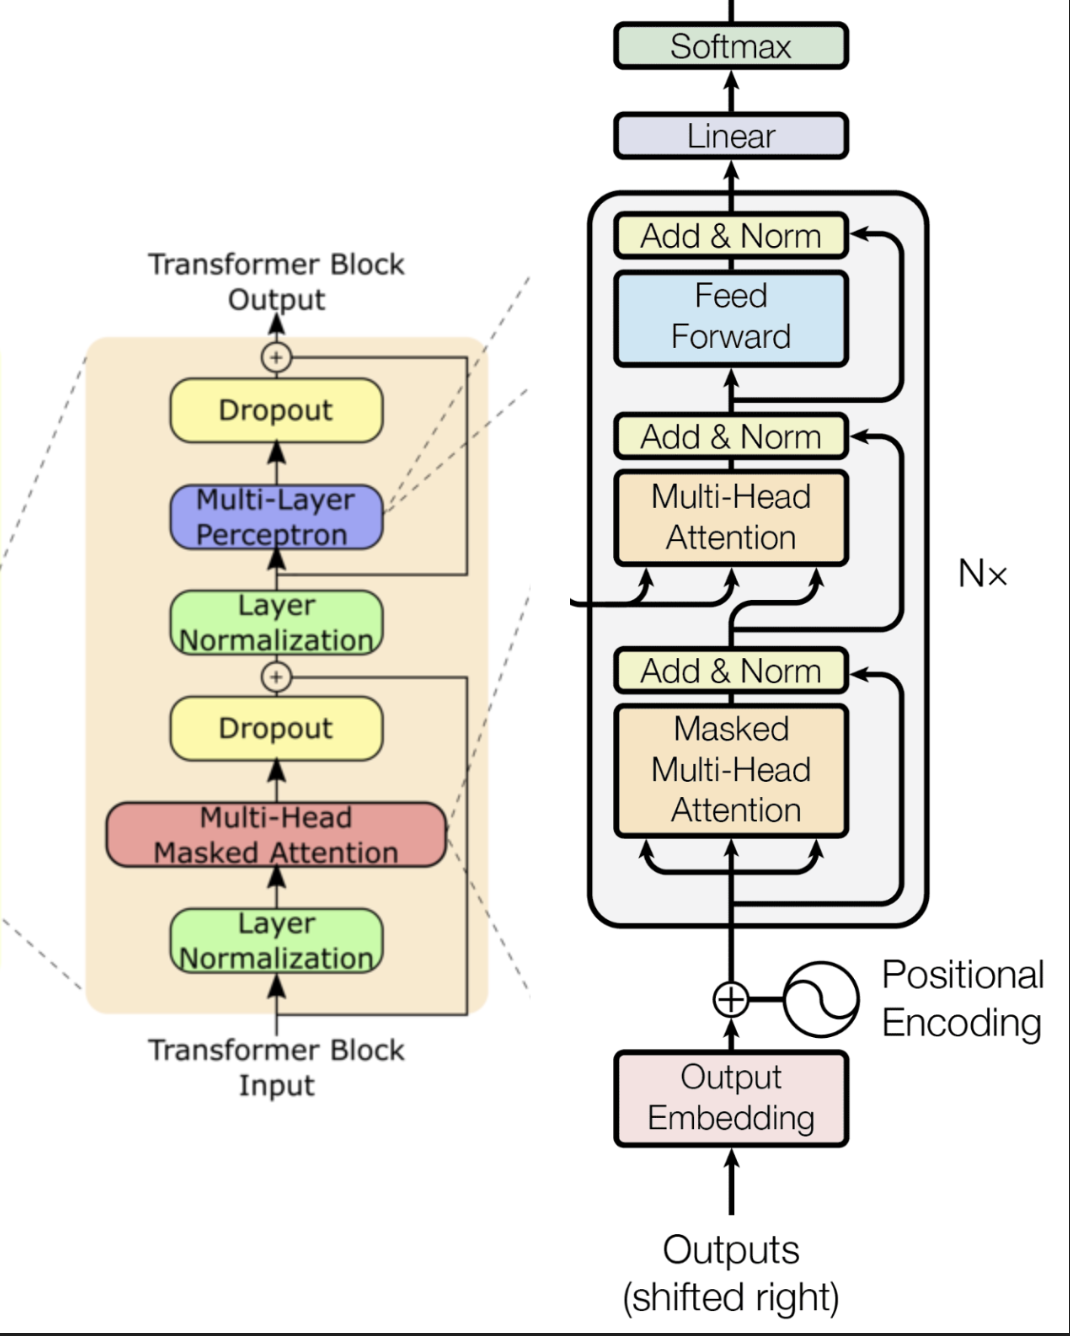

In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel

# Huggingface GPT2 model

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

i = 0
for k, v in sd_hf.items(): 
    if i == 0:
        print(f"{k}, {v.shape} # Token Embedding")
        i += 1
        continue
    if i == 1:
        print(f"{k}, {v.shape} # Position Embedding")
        i += 1
        continue
    print(k, v.shape)

# free up memory
del model_hf
del sd_hf

transformer.wte.weight, torch.Size([50257, 768]) # Token Embedding
transformer.wpe.weight, torch.Size([1024, 768]) # Position Embedding
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768

# GPT Model

## Config

In [3]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # maximum sequence length
    vocab_size: int = 50257 # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding size

In [4]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

## Transformer Block

In [5]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate = "tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

### Attention

In [7]:
# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                            .view(1, 1, config.block_size, config.block_size))
    
    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size() 
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        # Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # apply the mask
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # apply the softmax
        att = F.softmax(att, dim=-1)
        # apply the attention
        y = att @ v
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y

In [8]:
# Example by numbers
n_embd = GPTConfig.n_embd
n_head = GPTConfig.n_head
print(f"n_embd = {n_embd} | n_head = {n_head}")
print(f"Head size should be: {n_embd // n_head}")
print("-" * 50)

c_attn = nn.Linear(n_embd, n_embd * 3)
c_proj = nn.Linear(n_embd, n_embd)

# Random input (Batch size 2, sequence length 4, embedding size is n_embd)
x = torch.randn(2, 4, n_embd)
B, T, C = x.size()
print(f"B = {B} | T = {T} | C = {C}")
qkv = c_attn(x)
print(f"Shape of qkv: {qkv.shape}")
q, k, v = qkv.split(C, dim=2)
print(f"Shapes of q, k, v: {q.shape}, {k.shape}, {v.shape}")

# Reshape the key, query, value (to have n_heads)
k = k.view(B, T, n_head, C // n_head).transpose(1, 2)
q = q.view(B, T, n_head, C // n_head).transpose(1, 2)
v = v.view(B, T, n_head, C // n_head).transpose(1, 2)
print(f"Shapes of q, k, v after reshaping: {q.shape}, {k.shape}, {v.shape}")

n_embd = 768 | n_head = 12
Head size should be: 64
--------------------------------------------------
B = 2 | T = 4 | C = 768
Shape of qkv: torch.Size([2, 4, 2304])
Shapes of q, k, v: torch.Size([2, 4, 768]), torch.Size([2, 4, 768]), torch.Size([2, 4, 768])
Shapes of q, k, v after reshaping: torch.Size([2, 12, 4, 64]), torch.Size([2, 12, 4, 64]), torch.Size([2, 12, 4, 64])


# Define GPT class again

In [9]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        return logits
    
    # Copy weights from hf model to our model
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# Running the model

## Loading the weights

In [10]:
model = GPT.from_pretrained('gpt2')
print("no issues loading the model")

loading weights from pretrained gpt: gpt2
no issues loading the model


## Running Huggingface GPT2 model

In [11]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2', device = "mps")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

/Users/usamaahmed/miniconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "Hello, I'm a language model, and my project will get better with time, but I think there are a lot more things that can help you"},
 {'generated_text': "Hello, I'm a language model, not a language model, so if I don't have a problem, I can fix it by creating new words"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to learn some stuff. I'll try to do some basic programming and just learn better ways"},
 {'generated_text': "Hello, I'm a language model, but I don't believe in grammar. This will work for every language model. You can define it very quickly"},
 {'generated_text': 'Hello, I\'m a language model, a model of how things should be, and then we look at different things as well." I\'d like to'}]

## Running our model

### Prepare Tokens

In [12]:
num_return_sequences = 5
max_length = 30
model.eval()
# Run on Apple Silicon GPU (Change it to "cuda" according to your setup)
model.to("mps")

# Create the prefix tokens
import tiktoken
enc = tiktoken.get_encoding("gpt2")
text = "Hello, I'm a language model,"
tokens = enc.encode(text)
print(f"Tokens: {tokens}")
tokens = torch.tensor(tokens, dtype=torch.long) # Shape is (T)
print(f"Shape of tokens is {tokens.shape}")
tokens = tokens.unsqueeze(0) # Shape is (B, T)
print(f"Shape of tokens is {tokens.shape}")
tokens = tokens.repeat(num_return_sequences, 1) # Shape is (num_return_sequences, T)
print(f"Shape of tokens is {tokens.shape}")
# move to device
x = tokens.to("mps")

Tokens: [15496, 11, 314, 1101, 257, 3303, 2746, 11]
Shape of tokens is torch.Size([8])
Shape of tokens is torch.Size([1, 8])
Shape of tokens is torch.Size([5, 8])


### Decode the tokens

In [13]:
torch.manual_seed(42)
torch.mps.manual_seed(42) # or torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        # run the model
        logits = model(x) # Shape is (B, T, vocab_size)
        logits = logits[:, -1, :] # Shape is (B, vocab_size)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim = -1)
        # do top_k sampling of 50
        topk_probs, topk_indices = torch.topk(probs, 50, dim = -1)
        # select a random token from the topk
        ix = torch.multinomial(topk_probs, 1) # Shape is (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # Shape is (B, 1)
        # concatenate to the sequence
        x = torch.cat((x, xcol), dim = 1)

print(f"Shape of x is {x.shape}")

Shape of x is torch.Size([5, 30])


In [14]:
# Print the generated text (Not the same as the Huggingface model, due to the pipeline not the model architecture)
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist() # No need to add :max_length since the generation already stops
    decoded = enc.decode(tokens)
    print(f"{decoded}")

Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because


### Use GPT2 Tokenizer (From 🤗 Transformers)
Should print the same output

In [15]:
# TODO Try using GPT2 Tokenizer (From Huggingface)
from transformers import GPT2Tokenizer
tokens = GPT2Tokenizer.from_pretrained("gpt2").encode(text, return_tensors="pt")
print(f"Tokens: {tokens}")
print(f"Shape of tokens is {tokens.shape}")
tokens = tokens.repeat(num_return_sequences, 1) # Shape is (num_return_sequences, T)
print(f"Shape of tokens is {tokens.shape}")
x = tokens.to("mps")

Tokens: tensor([[15496,    11,   314,  1101,   257,  3303,  2746,    11]])
Shape of tokens is torch.Size([1, 8])
Shape of tokens is torch.Size([5, 8])


In [16]:
torch.manual_seed(42)
torch.mps.manual_seed(42) # or torch.cuda.manual_seed(42)
while x.shape[1] < max_length:
    with torch.no_grad():
        # run the model
        logits = model(x) # Shape is (B, T, vocab_size)
        logits = logits[:, -1, :] # Shape is (B, vocab_size)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim = -1)
        # do top_k sampling of 50
        topk_probs, topk_indices = torch.topk(probs, 50, dim = -1)
        # select a random token from the topk
        ix = torch.multinomial(topk_probs, 1) # Shape is (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # Shape is (B, 1)
        # concatenate to the sequence
        x = torch.cat((x, xcol), dim = 1)

print(f"Shape of x is {x.shape}")

Shape of x is torch.Size([5, 30])


In [17]:
# Print the generated text (Not the same as the Huggingface model, due to the pipeline not the model architecture)
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist() # No need to add :max_length since the generation already stops
    decoded = enc.decode(tokens)
    print(f"{decoded}")

Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because
